In [2]:
import numpy as np
import matplotlib.pyplot as plt

Байесовская линейная регрессия

Предполагаем, что данные сгенерированы из $y = Xw + \varepsilon, ~~ w \sim \mathcal{N}(0, A^{-1}),~~ \varepsilon \sim \mathcal{N}(0, \sigma^2 I)$. 

Для нее считается обоснованность
$$
p(y|X, A, \sigma^2) = \mathcal{N}(0, \sigma^2 I + X A^-1, X^T)
$$
Тогда:

$$
\log p(y|X, A, \sigma^2) \propto -\frac{1}{2} \log\det (\sigma^2 I + X A^{-1}X) -\frac{1}{2} y^T(\sigma^2 I + X A^{-1}X)y
$$


рассмотрим на примере $y_i = \sin x_i + \varepsilon_i$

рассмотрим что будет происходить при усложнении модели $M_k(x) = \sum^k_{i=0} w_i x^i$

In [3]:
sigma_sq = 0.1
alpha = 0.01


def gen_w(n):
    return np.random.normal(loc=0,scale= alpha**(-0.5), size=(n,))
gen_w(3)

def gen_x():
    return (np.random.rand() -0.5) * np.pi

def f(x):
    return np.sin(x) + np.random.rand() * (sigma_sq**0.5)

def make_X(x,n):
    """
    делает матрицу из степеней x
    """
    return np.vander(x, n)


def compute_log_evidence(x, y, sigma_sq, alpha, n):
    m = len(x)
    A = 1/alpha * np.eye(n)

    X = make_X(x, n)
    tmp_mat = sigma_sq * np.eye(m) + X @ A @X.T
    rez = -0.5 * (np.log(np.linalg.det(tmp_mat)) + np.einsum("i,ij,j", y, tmp_mat, y))
    return rez
    
k = 2000
x_s = np.array([gen_x() for _ in range(k)])
y_s = np.array([f(x) for x in x_s])
                            

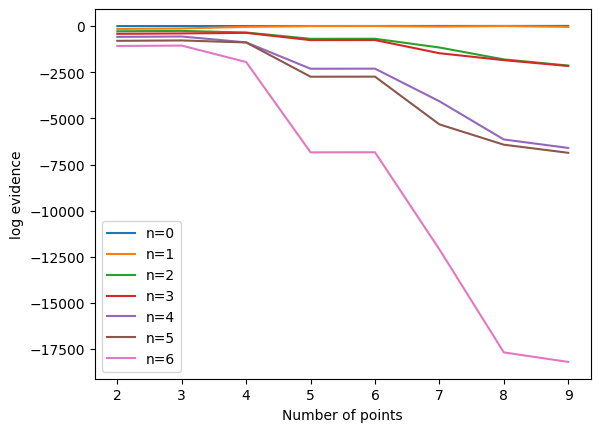

In [7]:
fig,ax = plt.subplots()
for n in [0, 1,2,3,4,5,6]:
    alg_rez = []
    num_points = list(range(2, 10, ))
    for num in num_points:
        log_ev = compute_log_evidence(x_s[:num], y_s[:num], sigma_sq, alpha, n)
        alg_rez.append(log_ev)
    ax.plot(num_points, alg_rez, label = f"{n=}")
plt.xlabel("Number of points")
plt.ylabel("log evidence")
plt.legend()

1) показан байесовский инференс, когда постериор можно точно считать

2) видим, что у слишком простых моделей evidence маленький. Также у слишком сложных моделей. Они начнут работать, когда будет больше данных.

тест кода

кусок из курса генеративок, нам нужно только 

In [1]:
from torch.utils.data import Dataset, DataLoader
%load_ext autoreload
%autoreload 2

from src.model_handler.bayess_net import ModelHandler
from src.utils.drawer import plot_grad_flow
from src.model.mlp import MLP

import torch



from src.data import load_dataset
train_data, train_labels, test_data, test_labels = load_dataset("mnist", flatten=False, binarize=True, with_targets=True)


use_cuda = False
batch_size = 256

class MyDataset(Dataset):
    def __init__(self, x, y):
        # super(MyDataset, self).__init__()
        self.x = torch.tensor(x)#.reshape(len(x), -1)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
train_dataset = MyDataset(train_data, train_labels)
test_dataset = MyDataset(test_data, test_labels)

if use_cuda:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
    valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                            )
    valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            )

пока сделаем тупую модель, которая будет работать с плоскими картинками

Start of the training


Evaluating epoch 10: 100%|██████████| 40/40 [00:02<00:00, 13.47it/s]


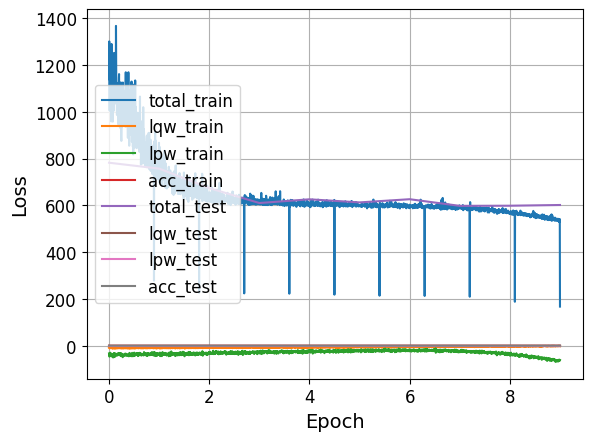

End of the training


In [30]:
from src.training import train_model
from src.priors.priors import laplace_prior
from torch.nn import functional as F
import torch.nn as nn

model = MLP([64, 50, 10])
model = ModelHandler(model, prior= laplace_prior(mu=0, b=0.1))

model = nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=2),
    nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=2),    
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    model
)
def loss(self, x, y):
        nsamples = 10
        loss = 0.
        Lqw, Lpw = 0, 0
        acc = 0.
        for _ in range(nsamples):
            labels, lqw, lpw = self(x)#, torch.tensor(0),torch.tensor(0)
            cross_entropy = F.cross_entropy(labels, y, reduction='sum')
            loss_tmp = cross_entropy + (lpw - lqw)# /x.shape[0] # нормируем на размер батча
            loss += loss_tmp
            Lqw += lqw.detach()
            Lpw += lpw.detach()
            acc += torch.mean((labels.detach().argmax(-1) == y).float())
        Lqw = Lqw / nsamples
        Lpw = Lpw / nsamples
        acc = acc / nsamples
        loss = loss / nsamples

        return {"total": loss, "lqw": Lqw, "lpw": Lpw, "acc": acc}
import types
# Create a method wrapper using types.MethodType
# m.myFunc = types.MethodType(myFunc, m)
model.loss = types.MethodType(loss, model)

model.train()

opt = torch.optim.Adam(model.parameters()) #, lr = 0.01) #, lr=0.001)

train_losses, test_losses = train_model(model, train_loader=trainloader, test_loader=valloader, epochs=10,
            optimizer= opt, loss_key= 'total', visualize_samples=False)

In [ ]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

Start of the training


Evaluating epoch 10: 100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


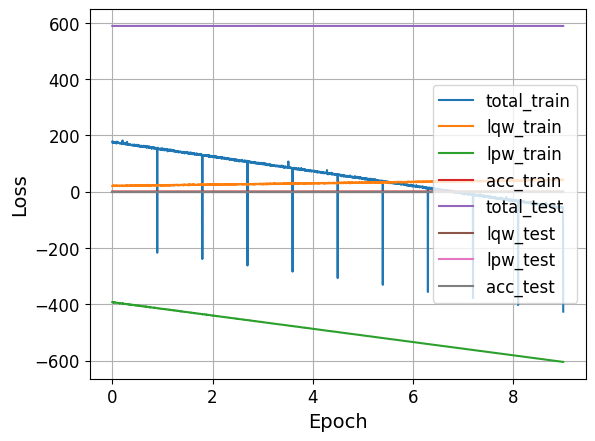

End of the training


In [44]:
if False: #torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

train_losses, test_losses = train_model(model, train_loader=trainloader, test_loader=valloader, epochs=10,
            optimizer= opt, loss_key= 'total', visualize_samples=False, device = device)

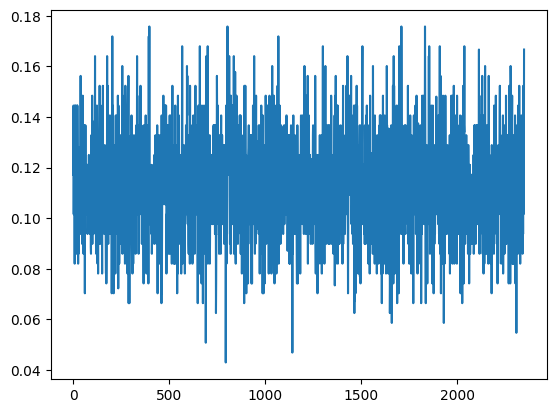

In [46]:
import matplotlib.pyplot as plt
plt.plot(train_losses['acc'])
plt.show()

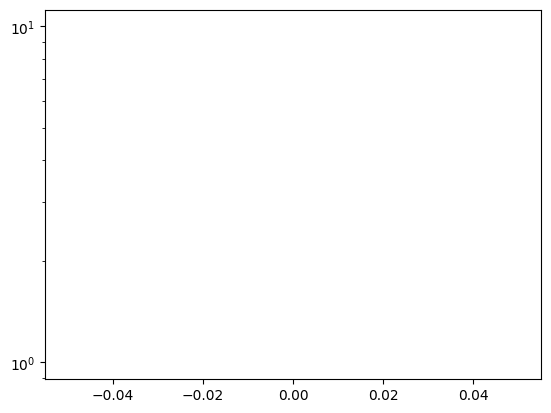

lpw


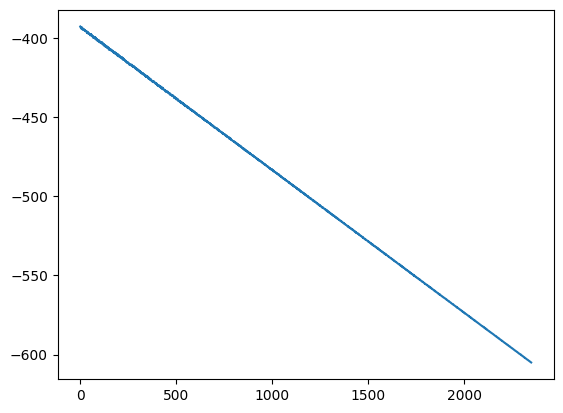

lqw


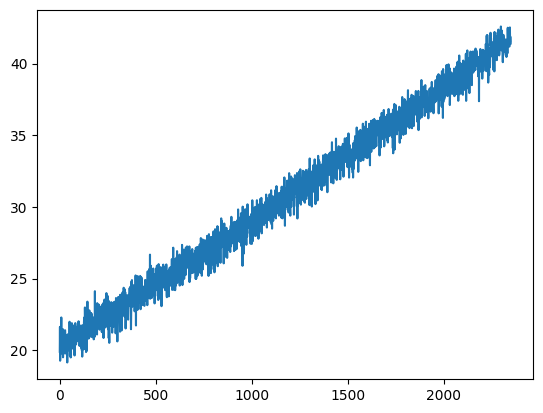

In [47]:
import matplotlib.pyplot as plt
plt.plot(train_losses['cross_entropy'])
plt.yscale("log")
plt.show()
print("lpw")
plt.plot(train_losses["lpw"])

plt.show()
print("lqw")
plt.plot(train_losses["lqw"])
# plt.plot(test_losses['acc'])

In [34]:
bmodel = model[-1]

(array([ 19.,  71., 195., 242., 257., 598., 506., 519., 453., 340.]),
 array([-0.31293416, -0.27060303, -0.22827187, -0.18594073, -0.1436096 ,
        -0.10127845, -0.05894731, -0.01661617,  0.02571497,  0.06804612,
         0.11037726]),
 <BarContainer object of 10 artists>)

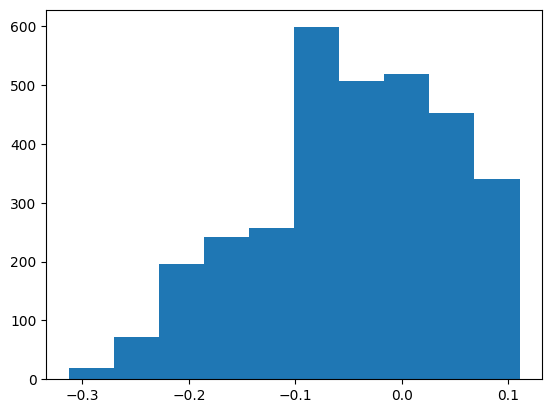

In [35]:
plt.hist(bmodel.sigma_params[0].detach().numpy().reshape(-1))

(array([ 69., 319., 344., 253.,  15.,   0.,  42., 734., 759., 665.]),
 array([-0.59716392, -0.52747351, -0.4577831 , -0.38809267, -0.31840226,
        -0.24871185, -0.17902143, -0.10933102, -0.03964061,  0.03004981,
         0.09974022]),
 <BarContainer object of 10 artists>)

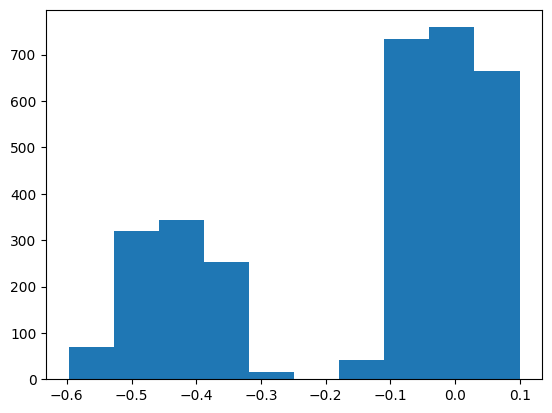

In [36]:
plt.hist(bmodel.mu_params[0].detach().numpy().reshape(-1))